In [5]:
from numpy.linalg import norm as np_norm
import numpy as np

In [6]:
def c_(x):
    return np.array(x)
norm_1 = lambda x: np.sum(abs(x))

In [21]:
RK_METHODS = {
    'FE':            [c_([[0]]), c_([1]), c_([0]),  False], #Explicit Euler
    'BE':            [c_([[1]]), c_([1]), c_([1]), True], #Implicit Euler
    'IMP':           [c_([[.5]]), c_([1]), c_([.5]), True], #Implicit Midpoint
    'ETrapz':        [c_([[0,0],[1,0]]), c_([.5,.5]), c_([0,1]),   False], # Explicit Trapezoidal
    'ITrapz':        [c_([[0,0],[.5,.5]]), c_([.5,.5]), c_([0,1]),  True], # Implicit Trapezoidal
    'RK4':           [c_([[0,0,0,0],[.5,0,0,0],[0,.5,0,0],[0,0,1,0]]), c_([1./6.,1./3.,1./3.,1./6.]), c_([0,.5,.5,1]),False], #Classical RK 4
    'RK4(3)I':       [c_([[.5,0,0,0],[1./6.,.5,0,0],[-.5,.5,.5,0],[1.5,-1.5,0.5,0.5]]), c_([1.5,-1.5,0.5,0.5]), c_([.5,2./3.,.5,1]), True], # Implicit stable RK 4 with 3 order of approx
    '3/8':           [c_([[0,0,0,0],[1./3.,0,0,0],[-1./3.,1,0,0],[1,-1,1,0]]), c_([.125, .475, .475, .125]), c_([0,1./3.,2./3.,1]) ,False],   # Classical #/8 rule of R-K
    'SSPRK3':        [c_([[0,0,0],[1,0,0],[.25, .25, 0]]), c_([1./6., 1./6., 2./3.]), c_([0,1.,1./2.]), False] # Third-order Strong Stability Preserving Runge-Kutta
}
RK_NAMES = {
    'FE':            'Explicit Euler',
    'BE':            'Implicit Euler',
    'IMP':           'Implicit Midpoint',
    'ETrapz':        'Explicit Trapezoidal',
    'ITrapz':        'Implicit Trapezoidal',
    'RK4':           'Classical RK 4',
    'RK4(3)I':       'Implicit stable RK 4 with 3 order of approximation',
    '3/8':           'Classical #/8 rule of R-K',
    'SSPRK3':        'Third-order Strong Stability Preserving Runge-Kutta'
    
}

In [16]:
def fixedp(f,x0,tol=10e-7, max_iter=100, log=True, nrm=norm_1):
    """ 
     Fixed point algorithm 
    >IN  ____________________________________________________________________________________________
          log         - if True dispatch warning if there is no convergence on maxiter-th step
          f           - function from `f(x)=x` equation
          x0          - initial guess about the root
          tol         - maximal allowed differ (measure of convergence)
          max_iter    - maximal allowed number of iterations before convergence
          nrm         - estimator of (x_i - x_i-1)=`steps diifer` or error. If error < tol   return  x=root
         --------------------------------------------------------------------------------------------
    
    <OUT ____________________________________________________________________________________________
          x'           - root of `f(x) = x` equation
         ____________________________________________________________________________________________
    !!    x0 and f(x0) must be scalars or numpy.arrays-like
     
     Fixed point considered to work with `k=f(...,...k)` as type of `f(x)=x` equations --  equations from \
     RK method. We will use it in Implicit RK because we need to solve system of nonlinear \
     algebraic equations
    """
    err=0
    x = 0
    for itr in range(max_iter):
        x = f(x0)
        err = nrm(x-x0) 
        if err < tol:
            return x
        x0 = x
    if log:
        print("warning! didn't converge, err: ",err)
    return x

def implicit_RK(f,a,b,c,x,N,s,h, y0, nrm = norm1):
    """
        implementation of RK
        >IN ------------------------------------------------------------------------------------------------------
              f(t,u) or f(x,y) - right hand side function of ODE
              a,b,c            - Butcher tableau (see below)
              x                - the points x[n] in which we will count y[n] (numpy.array)
              N-1              - the number of points. if set 100, 99 will be returned. Or not, I don't give a fuck
              s                - number of stages in RK or, simplier
                                 maximal numerator (cn, for exzmple, or ann) in Butcher tablue
              h                - hop, step of integration                      / y1_0 \
              y0               - initial values, (y)|       without x0!!! y0 = |   *  |
                                                    |x=x0                      |   *  |
                                                                               \ yn_0 /
        
              nrm             - estimator of (x_i - x_i-1)=steps diifer in fixed point method see fixedp()
           ______________________________________________________________________________________________________
        
        
        fixed point method used to solve system of s nonlinear equations on each step to predict new y_n+1
       
       
       Butcher tableau 
       ----------------
        c0|a00 a01 a02 * * a0n
        c1|a10 a11 a12 * * a1n
        c2|a20 a21 a22 * * a2n
        * | *          *                  c| a
        * | *            *          or     |___
        cn|an0             ann             |b^T
          |______________
          | b0  b1  b2 * * bn
        
    """
    number_of_systems = y0.shape[0]
    y = np.zeros((N,number_of_systems))
    y[0] = y0
    for n in range(0,N-1):
        def k_eq(k):
            _arr_2 = lambda i : y[n]+ h*np.sum([k[j]*a[i][j] for j in range(s)], axis=0)
            return np.array([f(x[n]+c[i]*h, _arr_2(i)) for i in range(s)])
        k = fixedp(k_eq, np.ones((s,number_of_systems)))
        y[n+1] = y[n] + h*np.sum([b[i]*k[i] for i in range(s)], axis = 0)
    return x,y
  
def explicit_RK(f,a,b,c,x,N,s,h, y0):
    """
        implementation of RK
        ------------------------------------------------------------------------------------------------------
        see implicit_RK for interface info
        
        ______________________________________________________________________________________________________
        
        fixed point method used to solve system of s nonlinear equations on each step to predict new y_n+1
       
        
    """
    number_of_systems = y0.shape[0]
    y = np.zeros((N,number_of_systems))
    y[0] = y0
    k = np.zeros((s,number_of_systems))
    for n in range(0,N-1):
        y[n+1] = y[n] 
        for i in range(s):
            k[i] = f(x[n]+c[i]*h, y[n]+h*np.sum([a[i][j]*k[j] for j in range(i)] , axis=0) )
            y[n+1]+=h*b[i]*k[i]
    return x,y

def RK(f, y0, t0, T, N=1000, h=None, method = 'RK4', butcher  = None, implicit = None, nrm=norm_1):
    """
        Interface for explicit_RK and implicit_RK
        >IN  --------------------------------------------------------------------------------------
                method     - abbrevation from one of the Butcher tableau in RK_methods
                implicit   - if your butcher tableau is for implicit -- (explicit function is faster)
                T          - maximal t
                t0         - initial t
                butcher    - butcher tableau of custom RK
                See implicit_RK for more details
             ----------------------------------------------------------------------------------------
        
        <OUT ______________________________________________________________________________________
        
                identical to implicit_RK
             _____________________________________________________________________
        
        !!      set `t0,T and N` or `t0,T and h` 
        !!      set `butcher and implicit` or `method`
    
    
   
    """
    
    N=N+1
    if butcher is None:
        a,b,c,implicit = RK_METHODS[method]
    else:
        if implicit is None:
            implicit = True
        a,b,c, = butcher
    if h is None:
        h = (T-x0)/N
        t = np.linspace(x0,T,N)
    else:
        N = np.floor((T-t0)/h)
        t = np.arange(t0,t,h)
    s = a.shape[0]
    if implicit:
        return implicit_RK(f,a,b,c,t,N,s,h, y0, nrm=nrm)
    else:
        return explicit_RK(f,a,b,c,t,N,s,h, y0)

In [380]:
from functools import partial
class solver:
    """
        class for wrapping RK()
        on inition creating object which fixed RK method
        on calling call RK() with presetted method
        for more details see RK()
    
        similar (or not) to nodepy syntax
    """
    def __init__(self,name, method = None,butcher = None, implicit = None):
        if butcher is None:
            self.method = partial(RK, method = method)
        else:
             self.method = partial(RK, butcher = butcher, implicit = implicit)
        self.name = name
    def __call__(self, f, y0, t0, T, N=1000, h=None):
        return self.method(f, y0, t0, T, N=1000, h=None)

##  
##  
## Ниже примеры использования

In [3]:
import matplotlib.pyplot as plt

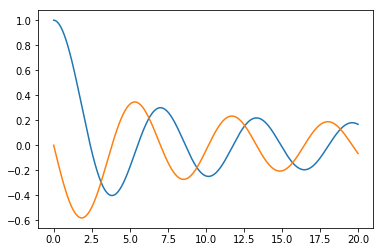

In [9]:
x0 = 1e-4
u0 = np.array([1-x0**2*0.2,
              -0.4*x0])
def f(x,y):
    return y[1],-y[0]
def fbessel(t, u):
    nu = 0.0
    y = u[0]
    v = u[1]
    dydx = v
    dzdx = -1.0/t*v-y
    return [dydx, dzdx]
#a,b,c = c_([[0]]), c_([1]), c_([0])
#a,b,c = c_([[0,0],[.5,.5]]), c_([.5,.5]), c_([0,1])
a,b,c = c_([[0,0,0,0],[.5,0,0,0],[0,.5,0,0],[0,0,1,0]]), c_([1./6., 1./3.,1./3.,1./6.]), c_([0,.5,.5,1])
N=10001
x = np.linspace(0+x0,20+x0,N)
y0 = c_([1,0])

t_,y_ = RK(f=fbessel, N = N, y0 = u0, t0=x0, T=x0+20)
plt.plot(t_,y_)


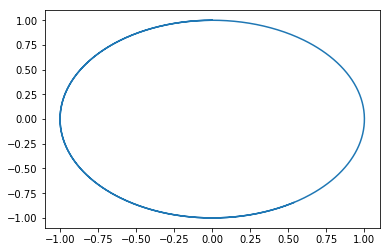

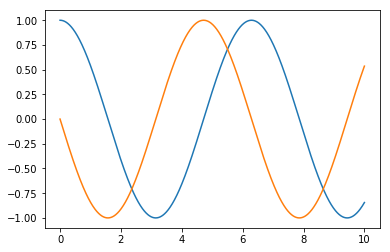

In [18]:
#определить функицию правой части. 1-ый аргумент -- время, 2-ой -- y,v и тд
def f(x,y):
    return y[1],-y[0]
y0 = c_([1,0]) #задать н.у.
N=1001 #количество шагов +/- 1
from RK import RK as vv 
t_,y_ = vv(f=f, N = N, y0 = y0, t0=0+1e-9, T=10, method = 'SSPRK3') #t_ - узлы, y_ = 
                                                    #массив точек фазовой рлоскости (y_i, v_i)
plt.plot(y_[:,1],y_[:,0]) #фзазовая траектория
plt.subplots()
plt.plot(t_,y_) # y(t), v(t)
#в данном случае, если взять н.у. (1,0), то может очень иногда выйти гавно, тогда немного сместить н.у.

In [15]:
#Перебрать все методы
from RK import  RK_METHODS, RK_NAMES, c_
from RK import RK as rk_solve
import matplotlib.pyplot as plt

def f(x,y):
    return y[1],-y[0]
t0=1e-15
T=10
y0 = c_([1,0]) #задать н.у.
N=1001 #количество шагов +/- 1
def plot_all_methods(f,N,y0,t0,T):
    for method in RK_METHODS.keys():
        t_,y_ = rk_solve(f=f, N = N, y0 = y0, t0=t0, T=T, method = method) 
        fig, axs = plt.subplots(1,2)  
        fig.set_figheight(5)
        fig.set_figwidth(12)
        axs[1].plot(y_[:,1],y_[:,0]) #фзазовая траектория
        axs[0].plot(t_,y_[:,0], label ="y") 
        fig.suptitle(RK_NAMES[method])
        axs[0].plot(t_,y_[:,1], label = "y'")# y(t), v(t)
        axs[0].legend()

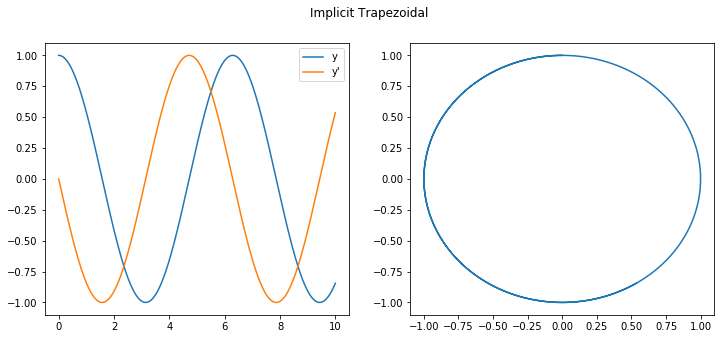

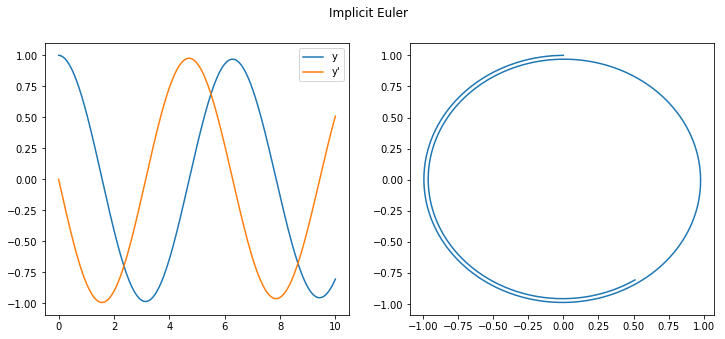

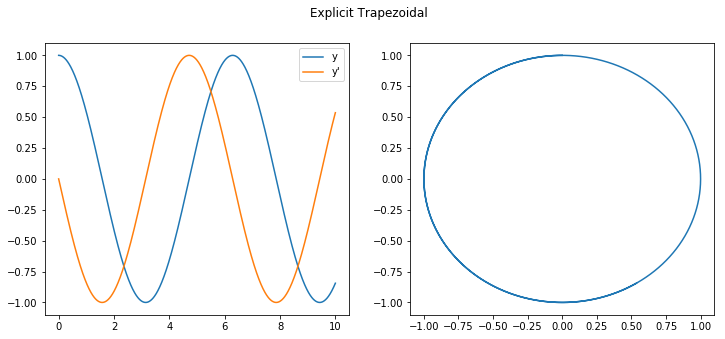

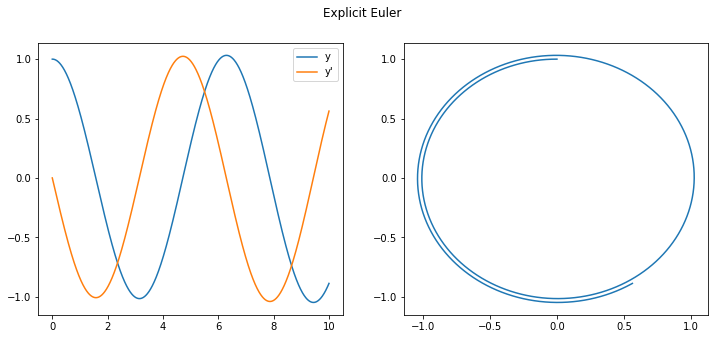

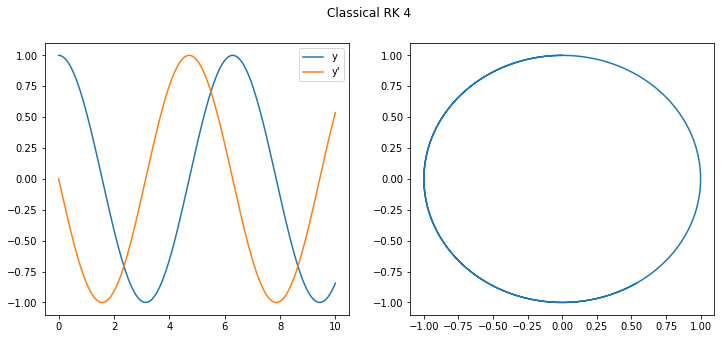

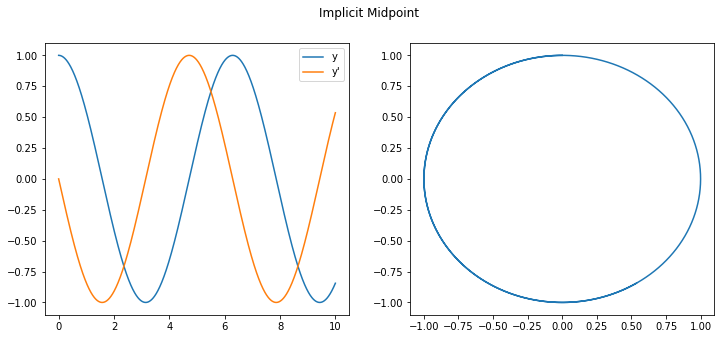

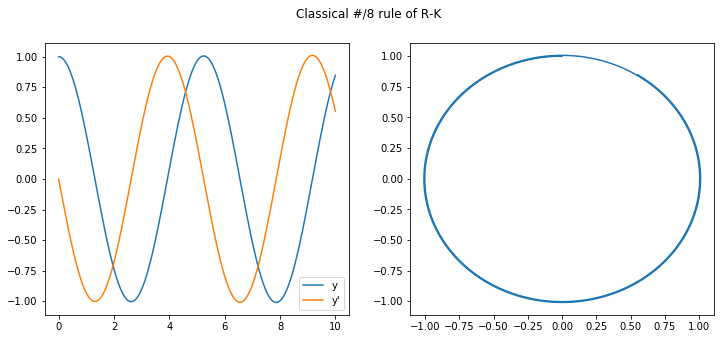

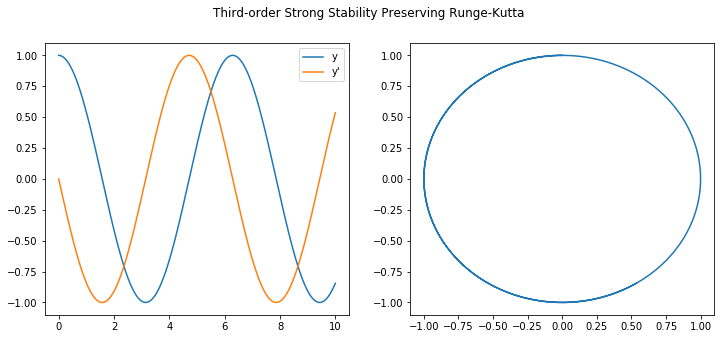

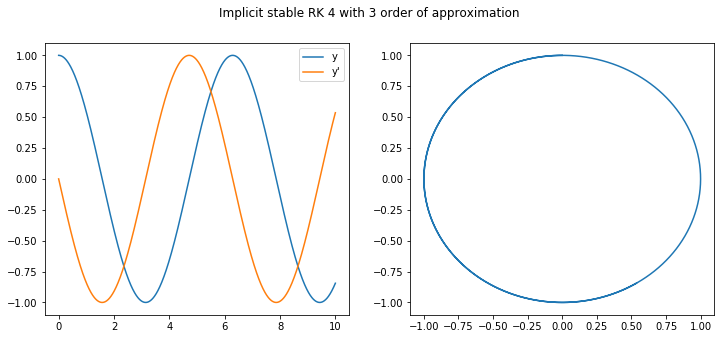

In [16]:
plot_all_methods(f,N,y0,t0,T)

In [ ]:
fig.su